# 1. Objective

In this project, image classification is performed using three different types of deep convolutional neural networks in order to learn and experiment with deep neural networks.

For the purpose of this project, the dataset was re-classified into 3 classes of fruits, vegetables, and packages. View readme for more info.

# Some code snippets which might be useful to get you started

In [3]:
 !pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 665.5 MB 369 kB/s
     |████████████████████████████████| 1.3 MB 7.0 MB/s 
     |████████████████████████████████| 463 kB 50.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
    Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636


In [2]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

We now create some data generators for working with the flowers data

Adapt the code below to work with the generators, then proceed with the experiments!

# Run This: Confusion matrix function

In [4]:
#@title Run this confusion matrix function
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  


# 2. Initial Set-up

## 2.1 Mount Google Drive and set the train, validation, and test data set path

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
## set train, validation, and test paths
img_height, img_width = (224,224)
batch_size = 32
test_path = '/content/drive/MyDrive/Groceries/test' 
train_path = '/content/drive/MyDrive/Groceries/train'
val_path = '/content/drive/MyDrive/Groceries/val'

## 2.2 Intial preprocessing of data
This is the initial preprocessing of data without any data augmentation before the creation of the network. This is just the start.

In [8]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = batch_size)

validation_batches  = ImageDataGenerator().flow_from_directory(
    val_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = batch_size)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 1)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [9]:
#take a look at output of the generators

for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 3)


## 2.3 Sample images

Some vegetables and fruits have similar shapes while the inter-class variance to packages is high

# 3. Create a baseline Convolutional Neural Network (CNN) model and experiment

There are usually four main operations in a convolutional neural network, which are Convolution, Activation Functions, Pooling or Sub Sampling and Classification (Fully Connected Layer).

In the first step, the features are extracted from the input image. Small squares of input data are learned in the Convolution operation and ensure that the spatial relationship between pixels of a picture sustain. While different feature maps from the same original image are produced by different filters, the local dependencies of the original image are captured. After specifying numerous parameters, such as architecture of the network, filter size etc., the network can learn the value of the specified filters independently. Thereby, increasing the number of filters, also increases the network´s ability to recognize patterns in new images.

The depth, the stride and the zero-padding control the feature map (Convolved Feature).
Next, the Rectified Linear Unit operation, is an element wise non-linear operation that is applied per pixel sets zero values for all negative pixel values. Introducing non-linearity is important since the convolution operation is a linear one for the model, but this assumption does not hold in real life. The rectified feature map is the output feature map.

Following, spatial pooling, also called subsampling or downsampling, is used to make the feature dimensions and number of parameters smaller to make it more manageable and avoid overfitting. In this step the dimensionality of the different feature maps is reduced while the most relevant information is kept.

Last, in the fully connected layer the input image is classified into various classes based on the training dataset. This layer allows to combine features from the convolutional and pooling layers.

In the following model,  a sequential convolutional neural network that takes an input image of size 224, 224, with 3 channels is created. This model does not include any regularization, and in the first iteration, will not be tested with data augmentation either, this is done in order to set the baseline.

The model uses the similar techniques described in lab 4 where it has alternates of Conv2D layers and MaxPooling2D layers. 

Since there are 1500 total large images, we continued by having four Conv2D layers alternating with MaxPooling2D layers. The initial layer has a depth of 32 with 3x3 matrix, feature map of 224x224, using activation function 'relu'. Then a MaxPooling2d is applied, where all clusters of neurons's outputs are pushed into a single neuron into the next Conv2D Layer.

As this process is being done layer-by-layer, the feature-map decreases from 224x224 to 12x12, while the depth increases from 32, to 64, to 128 as a common pattern in all convolutional neural networks, to increase complexity with number of filters being used. 

Then the Fully connected layer (Dense layer) connects the outputs of previous layer, where output from the final MaxPooling2D layer is flattened, with the final output Dense layer with size 3, as the problem has three classes, making it a categorical class, also requiring softmax  activation.

In [10]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

### 3.1 Compile and fit Run 1

The model is compiled and fit without any data augmentation and  regularization, using RMSprop optimizer with a learning rate of 0.0001. The loss type is categorical crossentropy because we have a categorical analysis problem. This was done in order to create the baseline train and validation results in order to see how the model can be improved.

The train batch size is 50, validation batch size is 10. The train and validation steps is calculated based on the number of images present in the generators. 

In [141]:
## set steps per epoch for train
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

## set steps per epoch for validation
validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
fit_generator1 = model.fit_generator(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=10,
      validation_data=validation_batches,
      validation_steps=steps_valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
82/82 [==============================] - 676s 8s/step - loss: 0.2488 - acc: 0.9235 - val_loss: 0.2211 - val_acc: 0.9426
Epoch 2/10
82/82 [==============================] - 14s 172ms/step - loss: 0.0363 - acc: 0.9883 - val_loss: 0.0902 - val_acc: 0.9730
Epoch 3/10
82/82 [==============================] - 14s 171ms/step - loss: 0.0148 - acc: 0.9962 - val_loss: 0.0642 - val_acc: 0.9696
Epoch 4/10
82/82 [==============================] - 14s 172ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0699 - val_acc: 0.9730
Epoch 5/10
82/82 [==============================] - 14s 171ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0648 - val_acc: 0.9764
Epoch 6/10
82/82 [==============================] - 14s 172ms/step - loss: 8.4915e-04 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9730
Epoch 7/10
82/82 [==============================] - 14s 171ms/step - loss: 6.5342e-04 - acc: 1.0000 - val_loss: 0.0718 - val_acc: 0.9730
Epoch 8/10
82/82 [==============================] - 14s 172ms/s

In [11]:

import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

#### Analysis of the first run result

As can be seen, the baseline model did not perform properly. 
Which can be due to many reasons such as lack of data, lack of regularization, lack of complexity, or sometimes just a poor model. In this case, I believe it could be due to lack of data as the model does not seem to be learning. Therefore, a good technique to begin adding more diverse data to the dataset is through data augmentation, which will be explained in the following section.



### 3.2 Perform Data Augmentation and Test Run 2

For the same model, we will add data augmentation. This is one of the most common ways to increase the size of the data set and also reduce overfitting. Since the previous run of the model provided inconclusive results, where the model does not seem to be learning, data augmentation can provide a larger and more diverse data set without changing the class labels.

Using training generators of augmented images and classes from flow_from_directory, data augmentation can compose random normalization and transformations operations to be done on image

The chosen data augmentations are of rescale, shear_range, zoom_range, and horizontal_flip. 
* rescale changes the input image pixels from [0,255] to [0,1]. 
* Shear_range applied random shear transfromations
* zoom_range randomly zooms inside images
* horizontal_flip is set to True, which flips the images horizontally

The RMSprop is continued to be used at the optimizer since we are compiling the same model.

[Read more on data augmentation](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

In [145]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

## set steps per epoch for validation
validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

fit_generator_3 = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=steps_valid)


Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
52/52 [==============================] - 52s 893ms/step - loss: 1.1536 - acc: 0.4261 - val_loss: 1.0493 - val_acc: 0.4020
Epoch 2/50
52/52 [==============================] - 40s 753ms/step - loss: 0.9970 - acc: 0.5280 - val_loss: 0.9567 - val_acc: 0.6115
Epoch 3/50
52/52 [==============================] - 41s 779ms/step - loss: 0.9373 - acc: 0.5720 - val_loss: 1.0370 - val_acc: 0.6081
Epoch 4/50
52/52 [==============================] - 41s 770ms/step - loss: 0.9308 - acc: 0.5693 - val_loss: 0.9159 - val_acc: 0.5709
Epoch 5/50
52/52 [==============================] - 39s 746ms/step - loss: 0.8910 - acc: 0.6087 - val_loss: 0.9165 - val_acc: 0.5507
Epoch 6/50
52/52 [==============================] - 41s 780ms/step - loss: 0.8860 - acc: 0.6019 - val_loss: 1.0154 - val_acc: 0.4662
Epoch 7/50
52/52 [==============================] - 39s 746ms/step - loss: 0.8480 - acc: 0.6398 - val_loss: 0.9001 - val_acc: 0.5743
Epoch 8/50
52/52 [==============================] - 40s 750ms/step - 

In [146]:
model.save('groceries_basic_model_da1')

INFO:tensorflow:Assets written to: groceries_basic_model_da1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


##### Plot accuracy vs loss

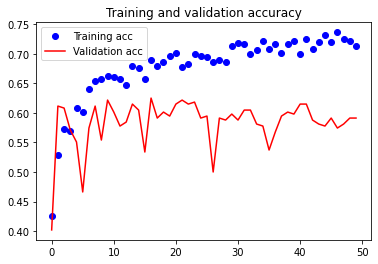

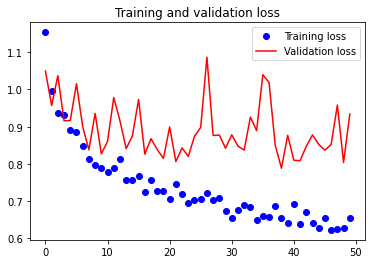

In [147]:

import matplotlib.pyplot as plt

acc = fit_generator_3.history['acc']
val_acc = fit_generator_3.history['val_acc']
loss = fit_generator_3.history['loss']
val_loss = fit_generator_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Analysis of previous result

These results are exciting because it can be seen through the graphs that the additional data through data augmentation had certainly made a difference. 

The training accuracy results range around 91-93% while the validation ranged around 83-85%.

It created more data and the model actually started training. The validation set still plateaus around the 85% accuracy around the 23rd epoch which means that the model might be over-fitting.

### 3.3 Augmant more Data Test Run 2

The attemp will be to add more data augmentation to improve the validation accuracy.

The chosen added data augmentations are of rotation_range, width_shift, height_shift, fill_mode. 
* rotation_range rotates the images at a given angle. 
* width_shift shifts the images withing the given range
* height_shift_range shifts the images randomly within the given range
* fill_mode is set to nearest

The RMSprop is continued to be used at the optimizer since we are compiling the same model.

The batch size has not been changed but the number of epochs were dropped from 50 to 30 in order to reduce the training time. This was due to the previous model's validation results become stagnant around the 23rd epoch; therefore, it is believed that we can see improved results with just 30 epochs.

In [150]:
## Added more types of Data Augmentation for experimenting
## Goal is to get more data

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

## set steps per epoch for validation
validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

fit_generator_4 = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=steps_valid)




Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
52/52 [==============================] - 46s 777ms/step - loss: 0.8278 - acc: 0.6402 - val_loss: 0.8250 - val_acc: 0.6014
Epoch 2/20
52/52 [==============================] - 40s 758ms/step - loss: 0.7414 - acc: 0.6674 - val_loss: 0.7929 - val_acc: 0.6149
Epoch 3/20
52/52 [==============================] - 40s 757ms/step - loss: 0.7626 - acc: 0.6667 - val_loss: 0.8250 - val_acc: 0.5946
Epoch 4/20
52/52 [==============================] - 42s 785ms/step - loss: 0.7488 - acc: 0.6807 - val_loss: 0.7989 - val_acc: 0.6149
Epoch 5/20
52/52 [==============================] - 41s 774ms/step - loss: 0.7680 - acc: 0.6701 - val_loss: 0.8208 - val_acc: 0.5878
Epoch 6/20
52/52 [==============================] - 40s 760ms/step - loss: 0.7166 - acc: 0.6932 - val_loss: 0.8275 - val_acc: 0.5777
Epoch 7/20
52/52 [==============================] - 40s 763ms/step - loss: 0.7467 - acc: 0.6659 - val_loss: 0.8077 - val_acc: 0.6014
Epoch 8/20
52/52 [==============================] - 40s 758ms/step - 

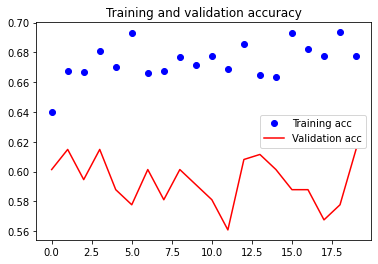

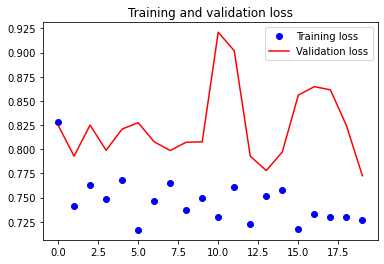

In [151]:

import matplotlib.pyplot as plt

acc = fit_generator_4.history['acc']
val_acc = fit_generator_4.history['val_acc']
loss = fit_generator_4.history['loss']
val_loss = fit_generator_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [152]:
model.save('groceries_basic_model_da2')

INFO:tensorflow:Assets written to: groceries_basic_model_da2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


#### Analysis of second addition of data augmentation


The training results range around 94-95% while the validation ranged around 88-92%. Which means that the addition data was influential however there was too much variance if the loss and accuracy graphs are taken a closer look. Adding regularization methods can further improve the model. However, we can see that having more epochs might not have improved the model as the results of validation plateau around the 24th epoch.

### 3.3 Regularization: Add dropout layer to model reduce overfitting

After viewing the previous results of runs 1, 2, and 3, we can conclude that the learning of the model has improved from each run but there is one common problem between all of them - model is overfitting. In order to reduce over-fitting, there are multiple design decisions that can be taken, such as regularization methods. Here, I chose to add a Dropout layer to regularize and stop overfitting.

To improve the learning, the batch size has been reduced to 20 and the will be trained to 50 epochs. The different types of images for each class and previous results were taken into consideration when making this decision

In [153]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(layers.Dense(3, activation='softmax'))
model2.summary()
model.save('groceries_basic_model_dropout')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 128)     

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


#### 3.3.1 Run regularized model

In [156]:
## Added more types of Data Augmentation for experimenting
## Goal is to get more data

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model2_fit_generator = model2.fit_generator(
        train_generator,
        steps_per_epoch=25,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=30)




Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
25/25 [==============================] - 12s 361ms/step - loss: 0.9776 - acc: 0.5500 - val_loss: 0.9744 - val_acc: 0.5372
Epoch 2/50
25/25 [==============================] - 9s 350ms/step - loss: 0.8099 - acc: 0.6860 - val_loss: 0.9159 - val_acc: 0.5946
Epoch 3/50
25/25 [==============================] - 9s 348ms/step - loss: 0.8101 - acc: 0.6200 - val_loss: 0.8925 - val_acc: 0.5709
Epoch 4/50
25/25 [==============================] - 9s 348ms/step - loss: 0.7593 - acc: 0.6720 - val_loss: 0.9378 - val_acc: 0.5743
Epoch 5/50
25/25 [==============================] - 9s 347ms/step - loss: 0.7060 - acc: 0.6840 - val_loss: 0.9764 - val_acc: 0.5946
Epoch 6/50
25/25 [==============================] - 9s 348ms/step - loss: 0.6855 - acc: 0.7040 - val_loss: 0.9264 - val_acc: 0.5777
Epoch 7/50
25/25 [==============================] - 9s 346ms/step - loss: 0.6959 - acc: 0.6940 - val_loss: 0.8852 - val_acc: 0.6115
Epoch 8/50
25/25 [==============================] - 9s 351ms/step - loss: 0

In [157]:
model2.save('groceries_basic_model_dropout')

INFO:tensorflow:Assets written to: groceries_basic_model_dropout/assets


#### Plot accuracy vs loss



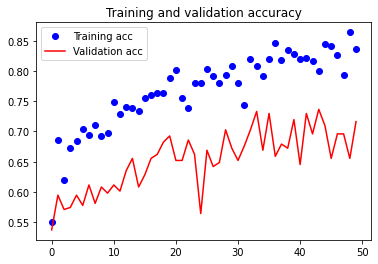

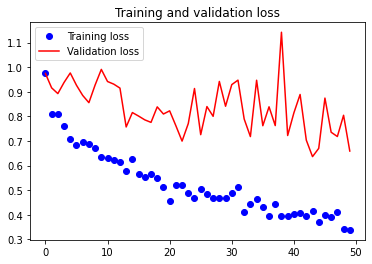

In [158]:

import matplotlib.pyplot as plt

acc = model2_fit_generator.history['acc']
val_acc = model2_fit_generator.history['val_acc']
loss = model2_fit_generator.history['loss']
val_loss = model2_fit_generator.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Analysis of regularized model

After seeing the results, this is the ideal graph for any model. Both the training accuracy and loss, and validation accuracy and loss are close. 

The training accuracy is around 90-92% while the validation is around 86%. 

The loss on the hand is around 0.21 for training and validation is slightly higher.

Therefore, this result can still be improved but they are satisfying enough to create a baseline prediction. Take a look at the predictions in the following section.

#### Predict and plot Confusion Matrix for baseline prediction

In [160]:
model2_test_datagen = ImageDataGenerator(rescale=1./255)

model2_test_generator = model2_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = model2_test_generator.filenames
nb_samples = len(filenames)

model2_predict = model2.predict_generator(model2_test_generator,steps = nb_samples, verbose=2)



Found 2485 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


2485/2485 - 198s - 198s/epoch - 80ms/step


Confusion matrix, without normalization
[[793  35 289]
 [  0 772   9]
 [110  19 458]]
['Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_002.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_003.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_004.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_005.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_006.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_007.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_008.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_009.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_010.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_011.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_012.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_013.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_014.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_015.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_016.jpg', '

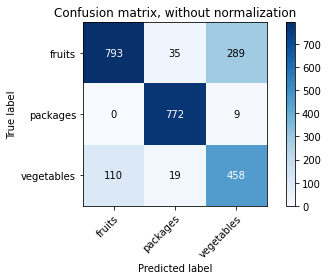

In [161]:
y_true = model2_test_generator.classes
y_pred = model2_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')
#plots(test_images, titles=test_labels)
print(filenames)

#### Analysis of the prediction

As can be seen in the confusion matrix, the packages were predicted at 100%, 62 images correctly categorized. This is probably because of its shape which is very different from the fruits and vegetables, a high inter-class variance.

On the contrary, both fruits and vegetables have similar shapes. Out of the 100 fruit images, 81 were predicted accurately, 15 predicted as vegetables, 4 as packages. 

For vegetables, 84 were predicted accurately, while 12 were classified as fruits, and 4 as packages, which is surprising. 

Hence, it can be concluded that this model is not good enough and can definitely be improved using other methods such as hyperparameter operations and testing (using grid search or thalos) or using pre-training networks. 

# 4. Fine-tune pre-defined network

Keras provides five convolutional neural networks, which are VGG16, VGG19, ResNet50, Inception V3 and Xception that can be used to classify images. 

For the project, I chose to use VGG16 and ResNet50 pre-trained model for transfer learning in order to compare and identify their perfomance of classifying this project's data set.

VGG is a sequential model, where it's architecture is a  consists of only 3x3 convolutional layers that increase in depth while they are stacked on top of each other and that are followed by two fully-connected layers (each with 4,096 nodes) and last by a softmax classifier. The major drawbacks of the VGG networks is that it is very slow and the weights of the network architecture are large in terms of disk/bandwidth.

ResNet is a functional model based on a network-in-network architecture, which describes its micro-architecture modules. Assembling the micro-architecture that construct the network leads to the macro-architecture, which is the final network. The ResNet architecture proves that by using residual models very deep networks can be trained with standard SGD. Although, the ResNet50 has 50 weight layers and is thus much deeper compared to a VGG16 or VGG19 network, the model size is smaller. This is due to the global average pooling that reduces the model size (102MB), while VGG uses fully-connected layers.

## 4.1 VGG16 Model

The following section described how the VGG16 model was used for transfer learning purposes but by freezing the weights that were trained on imagenet.

In [162]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights = 'imagenet')



553476096/553467096 [==============================] - 5s 0us/step


In [163]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.1.2 VGG16 run 1
To continue with previous baseline model, dense layer, drop out layer, and final dense layer were added after freezing the non-Fully connected layers.

In [164]:
from keras.models import Sequential
from keras.layers import Dense

vgg_transfer_base_model = Sequential()

for layer in vgg_model.layers[:-1]:
  vgg_transfer_base_model.add(layer)
  
vgg_transfer_base_model.layers.pop()
for layer in vgg_transfer_base_model.layers:
  layer.trainable=False

vgg_transfer_base_model.add(Dense(512, activation = 'relu'))
vgg_transfer_base_model.add(Dropout(0.5))
vgg_transfer_base_model.add(Dense(3, activation='softmax'))
vgg_transfer_base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

#### Data augmentation, compile, and fit generator

Continued data augmentation in order to provide good dataset.

In [168]:
## data augmentation datagen
vgg_train_datagen_do = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## test generator, required for prediction
vgg_test_datagen_do = ImageDataGenerator(rescale=1./255)

## train generator
vgg_train_generator_do = vgg_train_datagen_do.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## validation generator
vgg_validation_generator_do = vgg_test_datagen_do.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## compile model
vgg_transfer_base_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


## set steps per epoch for train
train_filenames_do = vgg_train_generator_do.filenames
steps_train_do = len(train_filenames_do)/vgg_train_generator_do.batch_size

## set steps per epoch for validation
validation_filenames_do = vgg_validation_generator_do.filenames
steps_valid_do = len(validation_filenames_do)/vgg_validation_generator_do.batch_size

## fit model
vgg_base_fit_generator_do = vgg_transfer_base_model.fit_generator(
        vgg_train_generator_do,
        steps_per_epoch=steps_train_do,
        epochs=30,
        validation_data=vgg_validation_generator_do,
        validation_steps=steps_valid_do,
        verbose=1)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
105/105 [==============================] - 51s 475ms/step - loss: 0.4630 - acc: 0.7841 - val_loss: 0.4570 - val_acc: 0.7162
Epoch 2/30
105/105 [==============================] - 43s 407ms/step - loss: 0.4298 - acc: 0.8000 - val_loss: 0.3582 - val_acc: 0.8446
Epoch 3/30
105/105 [==============================] - 44s 419ms/step - loss: 0.4196 - acc: 0.8034 - val_loss: 0.4029 - val_acc: 0.7973
Epoch 4/30
105/105 [==============================] - 42s 396ms/step - loss: 0.4174 - acc: 0.8030 - val_loss: 0.3882 - val_acc: 0.7534
Epoch 5/30
105/105 [==============================] - 42s 397ms/step - loss: 0.4089 - acc: 0.7955 - val_loss: 0.3464 - val_acc: 0.8480
Epoch 6/30
105/105 [==============================] - 42s 395ms/step - loss: 0.3967 - acc: 0.8155 - val_loss: 0.4103 - val_acc: 0.7770
Epoch 7/30
105/105 [==============================] - 43s 408ms/step - loss: 0.3955 - acc: 0.8163 - val_loss: 0.3258 - val_acc: 0.8784
Epoch 8/30
105/105 [==============================] - 4

#### Plot accuracy vs loss

In [169]:
vgg_transfer_base_model.save('vgg_model_dropout')

INFO:tensorflow:Assets written to: vgg_model_dropout/assets


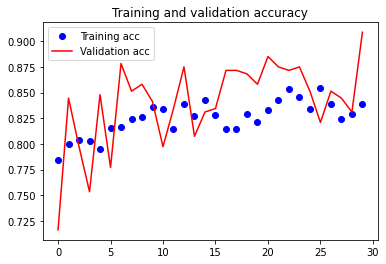

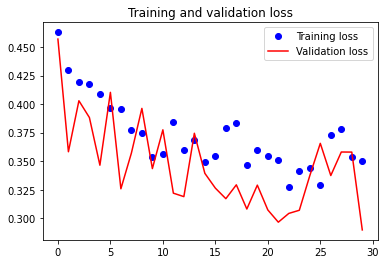

In [170]:

import matplotlib.pyplot as plt

acc = vgg_base_fit_generator_do.history['acc']
val_acc = vgg_base_fit_generator_do.history['val_acc']
loss = vgg_base_fit_generator_do.history['loss']
val_loss = vgg_base_fit_generator_do.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Predict

In [171]:
vgg_test_generator_do = vgg_test_datagen_do.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames_do = vgg_test_generator_do.filenames
nb_samples_do = len(filenames_do)

predict_do = vgg_transfer_base_model.predict_generator(vgg_test_generator_do,steps = nb_samples_do, verbose=2)


Found 2485 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


2485/2485 - 28s - 28s/epoch - 11ms/step


#### Confusion Matrix

Confusion matrix, without normalization
[[927  12 178]
 [  0 781   0]
 [117   9 461]]


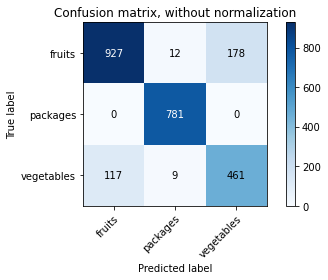

In [172]:
do_y_true = vgg_test_generator_do.classes
do_y_pred = predict_do.argmax(axis=1)
plot_confusion_matrix(do_y_true, do_y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')

#### Analysis of VGG16 with dropout layer


After transfer learning with VGG model, and including a drop out layer, the accuracy for validation is around 86-89%. This showed in the prediction, where 9 fruits were categorized incorrectly (8 as vegetables, 1 as package) and 17 vegetables were classed incorrectly (16 as fruits, 1 as package).

This model can be improved by removing the addition dropout layer used to prevent over-fitting as the graphs show that the train and validation in accuracy and loss are quite close to each other



### 4.1.3 VGG16 run 2
Removed the dropout layer because it seems I underfitted the data

In [173]:
from keras.models import Sequential
from keras.layers import Dense

vgg_transfer_base_model_2 = Sequential()

for layer in vgg_model.layers[:-1]:
  vgg_transfer_base_model_2.add(layer)
  
vgg_transfer_base_model_2.layers.pop()
for layer in vgg_transfer_base_model_2.layers:
  layer.trainable=False

vgg_transfer_base_model_2.add(Dense(512, activation = 'relu'))
#vgg_transfer_base_model_2.add(Dropout(0.5))
vgg_transfer_base_model_2.add(Dense(3, activation='softmax'))
vgg_transfer_base_model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [176]:
## data augmentation datagen

vgg_train_datagen_nd = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
## test generator, required for prediction
vgg_test_datagen_nd = ImageDataGenerator(rescale=1./255)
## train generator
vgg_train_generator_nd = vgg_train_datagen_nd.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## validation generator
vgg_validation_generator_nd = vgg_test_datagen_nd.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

vgg_transfer_base_model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

vgg_base_fit_generator_nd = vgg_transfer_base_model_2.fit_generator(
        vgg_train_generator_nd,
        steps_per_epoch=60,
        epochs=20,
        validation_data=vgg_validation_generator_nd,
        validation_steps=30,
        verbose=1)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
60/60 [==============================] - 26s 424ms/step - loss: 1.5064 - acc: 0.6927 - val_loss: 0.5461 - val_acc: 0.7162
Epoch 2/20
60/60 [==============================] - 25s 415ms/step - loss: 0.3958 - acc: 0.8220 - val_loss: 0.4177 - val_acc: 0.7939
Epoch 3/20
60/60 [==============================] - 24s 404ms/step - loss: 0.3740 - acc: 0.8215 - val_loss: 0.4462 - val_acc: 0.8209
Epoch 4/20
60/60 [==============================] - 24s 405ms/step - loss: 0.3591 - acc: 0.8349 - val_loss: 0.3551 - val_acc: 0.8480
Epoch 5/20
60/60 [==============================] - 26s 429ms/step - loss: 0.3435 - acc: 0.8380 - val_loss: 0.2976 - val_acc: 0.8818
Epoch 6/20
60/60 [==============================] - 24s 407ms/step - loss: 0.3336 - acc: 0.8490 - val_loss: 0.2986 - val_acc: 0.8716
Epoch 7/20
60/60 [==============================] - 24s 405ms/step - loss: 0.3289 - acc: 0.8450 - val_loss: 0.3205 - val_acc: 0.8514
Epoch 8/20
60/60 [==============================] - 24s 406ms/step - 

In [177]:
vgg_transfer_base_model_2.save('vgg_model_no_dropout')

INFO:tensorflow:Assets written to: vgg_model_no_dropout/assets


##### Plot

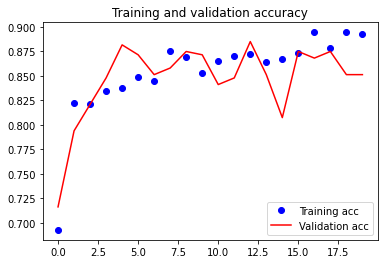

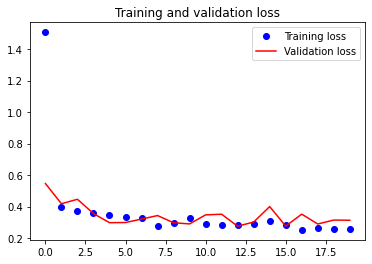

In [178]:
acc = vgg_base_fit_generator_nd.history['acc']
val_acc = vgg_base_fit_generator_nd.history['val_acc']
loss = vgg_base_fit_generator_nd.history['loss']
val_loss = vgg_base_fit_generator_nd.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### Predict

In [179]:
vgg_test_datagen_nd = ImageDataGenerator(rescale=1./255)

vgg_test_generator_nd = vgg_test_datagen_nd.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = vgg_test_generator_nd.filenames
nb_samples = len(filenames)

predict_nd = vgg_transfer_base_model_2.predict_generator(vgg_test_generator_nd,steps = nb_samples, verbose=2)


Found 2485 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


2485/2485 - 26s - 26s/epoch - 11ms/step


##### Confusion Matrix

Confusion matrix, without normalization
[[1059   12   46]
 [   0  781    0]
 [ 257   12  318]]


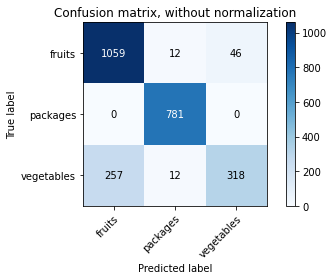

In [180]:
nd_y_true = vgg_test_generator_nd.classes
nd_y_pred = predict_nd.argmax(axis=1)
plot_confusion_matrix(nd_y_true, nd_y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')

#### Analysis of VGG16 model after removing dropout layer


After changing removing the dropout layer, the validation accuracy improved from 86% to 89-90% but the prediction results were very similar. 15 vegetables were classed incorrectly, with 3 fruits also classed incorrectly. The next attempt to improve the model can include hyperparameter optimization with changing the learning rate.





### 4.1.4 Hyperparameter tuning VGG16 run 3

* Continued with the previous model but with learning rate of 1e-5


In [12]:
## data augmentation datagen
## test generator, required for prediction
## train generator
## validation generator
## compile model
## set steps per epoch for train
## set steps per epoch for validation
## fit model
vgg_train_datagen_lr5 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

vgg_test_datagen_lr5 = ImageDataGenerator(rescale=1./255)

vgg_train_generator_lr5 = vgg_train_datagen_lr5.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

vgg_validation_generator_lr5 = vgg_test_datagen_lr5.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

vgg_transfer_base_model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

vgg_base_fit_generator_lr5 = vgg_transfer_base_model_2.fit_generator(
        vgg_train_generator_lr5,
        steps_per_epoch=60,
        epochs=10,
        validation_data=vgg_validation_generator_nd,
        validation_steps=30,
        verbose=1)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


NameError: ignored

##### Plot

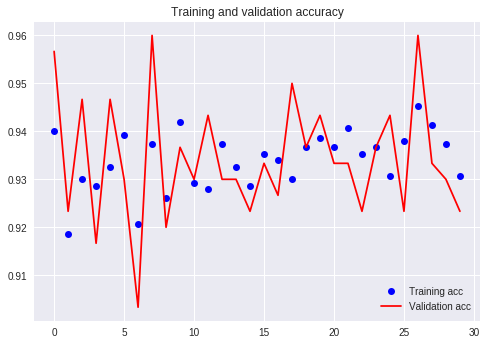

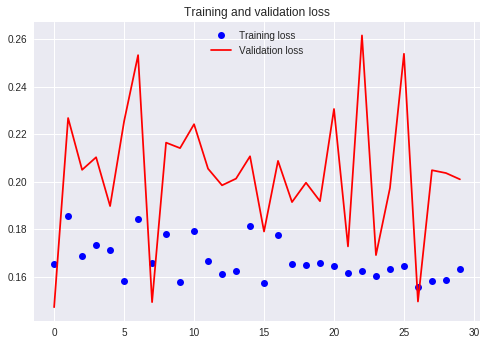

In [ ]:
acc = vgg_base_fit_generator_lr5.history['acc']
val_acc = vgg_base_fit_generator_lr5.history['val_acc']
loss = vgg_base_fit_generator_lr5.history['loss']
val_loss = vgg_base_fit_generator_lr5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### Predict

In [ ]:
vgg_test_datagen_lr5 = ImageDataGenerator(rescale=1./255)

vgg_test_generator_lr5 = vgg_test_datagen_lr5.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames_lr5 = vgg_test_generator_lr5.filenames
nb_samples_lr5 = len(filenames_lr5)

predict_lr5 = vgg_transfer_base_model_2.predict_generator(vgg_test_generator_lr5,steps = nb_samples_lr5, verbose=2)


Found 262 images belonging to 3 classes.


##### Confusion Matrix

Confusion matrix, without normalization
[[97  0  3]
 [ 0 62  0]
 [13  1 86]]


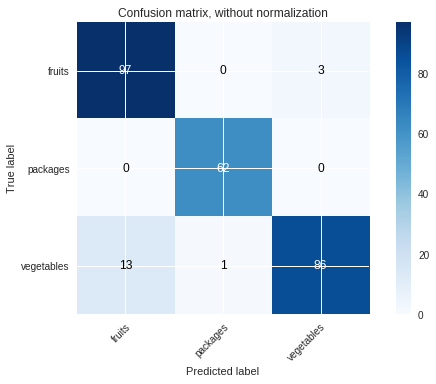

In [ ]:
lr5_y_true = vgg_test_generator_lr5.classes
lr5_y_pred = predict_lr5.argmax(axis=1)
plot_confusion_matrix(lr5_y_true, lr5_y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')

#### Analysis of VGG16 with hyperparameter tuning of learning rate


After changing the learning rate to 1e-5, the results were very consistent compared to VGG16 with learning rate 1e-4, showing 92-94% validation accuracy within all the epochs. However, the prediction did not change much as 14 different vegetables were classed incorrectly, and 3 fruits classed incorrected. Therefore, this model can still be improved, so the attempt will be transfer learn ResNet50.

Other ways to improve the model is through automatic hyperparameter optimization without using the data generators through the use of grid search (brute force) and thalos. However, in this model data generators have been used, preventing this method. Some optimizations could be to change the optimizers RMSprop to Adagard, Adam, or SGD.






## 4.2 ResNet50

In [ ]:
from keras.applications.resnet50 import ResNet50

resnet50_base_model = ResNet50(weights='imagenet', include_top=False)
#resnet50_trainable_model = ResNet50(weights=None, include_top=False)



ModuleNotFoundError: ignored

In [ ]:
resnet50_base_model.summary()

NameError: ignored

In [ ]:
## building base model with frozen weights

base_x = resnet50_base_model.output
global_pooling_x = GlobalAveragePooling2D()(base_x)
#add dense layer
dense_layer = Dense(512, activation='relu')(global_pooling_x)
#add final output layer
base_prediction = Dense(3, activation = 'softmax')(dense_layer)

#create the whole network
resnet_transfer_model_1 = Model(input=resnet50_base_model.input, outputs=base_prediction)

#resnet_transfer_model_1.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
resnet_transfer_model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


### Data augmentation and setting generator

In [ ]:
## Added more types of Data Augmentation for experimenting
## Goal is to get more data

res_train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

res_test_datagen = ImageDataGenerator(rescale=1./255)

res_train_generator = res_train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

res_validation_generator = res_test_datagen.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames_res = res_train_generator.filenames
steps_train_res = len(train_filenames_res)/res_train_generator.batch_size

## set steps per epoch for validation
validation_filenames_res = res_validation_generator.filenames
steps_valid_res = len(validation_filenames_res)/res_validation_generator.batch_size


print(len(validation_filenames_res), " ", steps_valid_res)

Found 1500 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
300   30.0


### Compile and fit model

In [ ]:
resnet_transfer_model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

resnet_model_1_fit_generator = resnet_transfer_model_1.fit_generator(
        res_train_generator,
        steps_per_epoch=steps_train_res,
        epochs=30,
        validation_data=res_validation_generator,
        validation_steps=steps_valid_res)


Epoch 1/30
75/75 [==============================] - 66s 876ms/step - loss: 0.2233 - acc: 0.9213 - val_loss: 0.3524 - val_acc: 0.9333
Epoch 2/30
75/75 [==============================] - 51s 682ms/step - loss: 0.1157 - acc: 0.9600 - val_loss: 0.6085 - val_acc: 0.9400
Epoch 3/30
75/75 [==============================] - 51s 680ms/step - loss: 0.0774 - acc: 0.9707 - val_loss: 0.5401 - val_acc: 0.9500
Epoch 4/30
75/75 [==============================] - 51s 682ms/step - loss: 0.0477 - acc: 0.9873 - val_loss: 2.2254 - val_acc: 0.8300
Epoch 5/30
75/75 [==============================] - 51s 679ms/step - loss: 0.0971 - acc: 0.9773 - val_loss: 0.4021 - val_acc: 0.9600
Epoch 6/30
75/75 [==============================] - 51s 681ms/step - loss: 0.0449 - acc: 0.9847 - val_loss: 5.5178 - val_acc: 0.6300
Epoch 7/30
75/75 [==============================] - 51s 681ms/step - loss: 0.0454 - acc: 0.9840 - val_loss: 1.4677 - val_acc: 0.8567
Epoch 8/30
75/75 [==============================] - 51s 681ms/step - 

In [ ]:
resnet_transfer_model_1.save('resnet50_frozen_model')

### Plot Accuracy and Loss

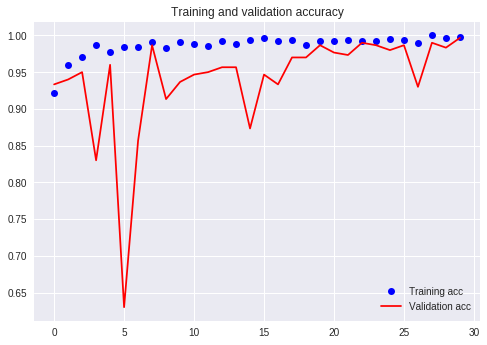

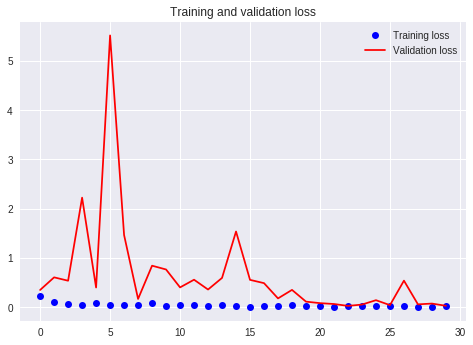

In [ ]:

import matplotlib.pyplot as plt

acc = resnet_model_1_fit_generator.history['acc']
val_acc = resnet_model_1_fit_generator.history['val_acc']
loss = resnet_model_1_fit_generator.history['loss']
val_loss = resnet_model_1_fit_generator.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predict

In [ ]:
resnet_test_datagen = ImageDataGenerator(rescale=1./255)

resnet_test_generator = resnet_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = resnet_test_generator.filenames
nb_samples = len(filenames)
#nb_samples


predict = resnet_transfer_model_1.predict_generator(resnet_test_generator,steps = nb_samples, verbose=2)


Found 262 images belonging to 3 classes.


### Confusion matrix

Confusion matrix, without normalization
[[ 99   0   1]
 [  0  62   0]
 [  0   0 100]]


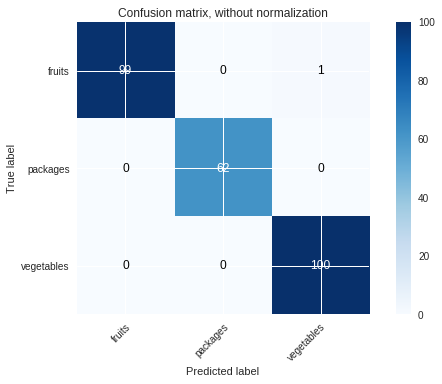

In [ ]:
r_y_true = resnet_test_generator.classes
r_y_pred = predict.argmax(axis=1)
plot_confusion_matrix(r_y_true, r_y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')

#### Analysis

After viewing the results of the accuracy and loss, and confusion matrix. This has proved to be the best model with 98-99% accuracy for validation and only 1 image classified incorrectly when predicted.

When the accuracy and loss graphs for training and validation are observed, it can been that the model is learning, starting from 92% accuracy (already very high but not surprising considering that it is being run on trained weights from imagenet) in the first epoch all the way up to 99%+. The validation results varied during the first 10 epochs but towards the end, the results were consistently around 98-99%. The performance is identical in the loss graph where the model shows consistent training and validation towards the last epoch. 

Since only one image was classified incorrectly, 99.62% of the images were corect, it can be concluded that this model is by far the best model.

# 5. Conclusion

When comparing the following accuracy of all the models:

1.   Baseline Convolution Model with dropout layer
 - validation accuracy around 86%, 35/262 images classified incorrectly
2.   VGG16 transfer model with dropout layer
 - validation accuracy range of 86-89%, 26/262 images classified incorrectly
3.   VGG16 transfer model without dropout layer
 - validation accuracy range of 89-90%, 18/262 images classified incorrectly
4.   VGG16 transfer model with learning rate changed from 1e-4 to 1e-5
 - validation accuracy range of 92-94%, 17/262 images classified incorrectly
5.   ResNet50 transfer model
 - validation accuracy around 99%, only 1/262 images classified incorrectly

The ResNet50 proved to be the best model in terms of both accuracy and loss. The accuracy validation results ranged around 98-99% while the confusion matrix described only one image (fruits) classified incorrectly. In conclusion, the problem of classifying different groceries at a high level can be solved using multiple convolutional neural networks such as the ResNet50. With a good, sufficient(large) dataset, this network can definitely be used in real life situations, the same cannot be said for the VGG models because the accuracy rates and predictons were not good enough.
